In [1]:
if 'google.colab' in str(get_ipython()):
        GITHUB_TOKEN = ""
        !rm -rf anti_money_laundering
        !git clone https://{GITHUB_TOKEN}@github.com/FedericoBruzzone/anti_money_laundering.git
        !mv anti_money_laundering/* 
        !rm -rf anti_money_laundering

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

import time
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from src.utils.kaggle_config            import setup_kaggle
from src.utils.kaggle_config            import download_dataset

from src.utils.datasets_handler         import get_train_and_test
from src.utils.datasets_handler         import get_X_and_Y
from src.utils.datasets_handler         import print_dataset
from src.utils.datasets_handler         import label_encoder
from src.utils.performance_measures     import calculate_performances
from src.utils.plot_measures            import (plot_correlation_matrix,  
                                                plot_numerical_histograms, 
                                                plot_roc_curve,
                                                plot_confusion_matrix)
from src.utils.dataset_sampling_methods import (oversampling,
                                                undersampling,
                                                bootstrap_sampling)

from src.decision_tree.decision_tree    import CustomDecisionTree
from src.decision_tree.ID3              import DecisionTreeID3
from src.decision_tree.entropy_type     import EntropyType
from src.decision_tree.criterion_type   import CriterionType

from IPython.display import Image, display

In [3]:
VERBOSE = int(os.getenv('VERBOSE'))
VIEW = os.getenv('VIEW')

setup_kaggle()
print("---------------------- Downloading dataset ----------------------") 
download_dataset("iammustafatz/diabetes-prediction-dataset")
download_dataset("ealtman2019/ibm-transactions-for-anti-money-laundering-aml")
print("---------------------- End downloading dataset ----------------------")

hi_small_trans = "HI-Small_Trans.csv"
diabetes = "diabetes_prediction_dataset.csv"

---------------------- Downloading dataset ----------------------
---------------------- End downloading dataset ----------------------


# Diabetes Dataset

In [4]:
df_train, df_test = get_train_and_test(diabetes, verbose=VERBOSE)
X_train, y_train = get_X_and_Y(df_train, verbose=VERBOSE)
X_test, y_test = get_X_and_Y(df_test, verbose=VERBOSE)
X_train, _ = label_encoder(X_train, ['gender', 'smoking_history'])
X_test,  _ = label_encoder(X_test, ['gender', 'smoking_history'])

### ID3

---------------------- ID3 --------------------------
PARAMETERS:
	MAX DEPTH: 10
	NUM THRESHOLDS NUMERICAL ATTR: 6


Performances: 
Fit time: 2.144319772720337 seconds
F1 score: 0.5441778818022236
Accuracy: 0.9480666666666666
Precision: 0.9989258861439313
Recall: 0.37394451145958985
True positive:  930
True negative:  27512
False positive:  1
False negative:  1557
True positive rate: 0.37394451145958985
False positive rate: 3.634645440337295e-05


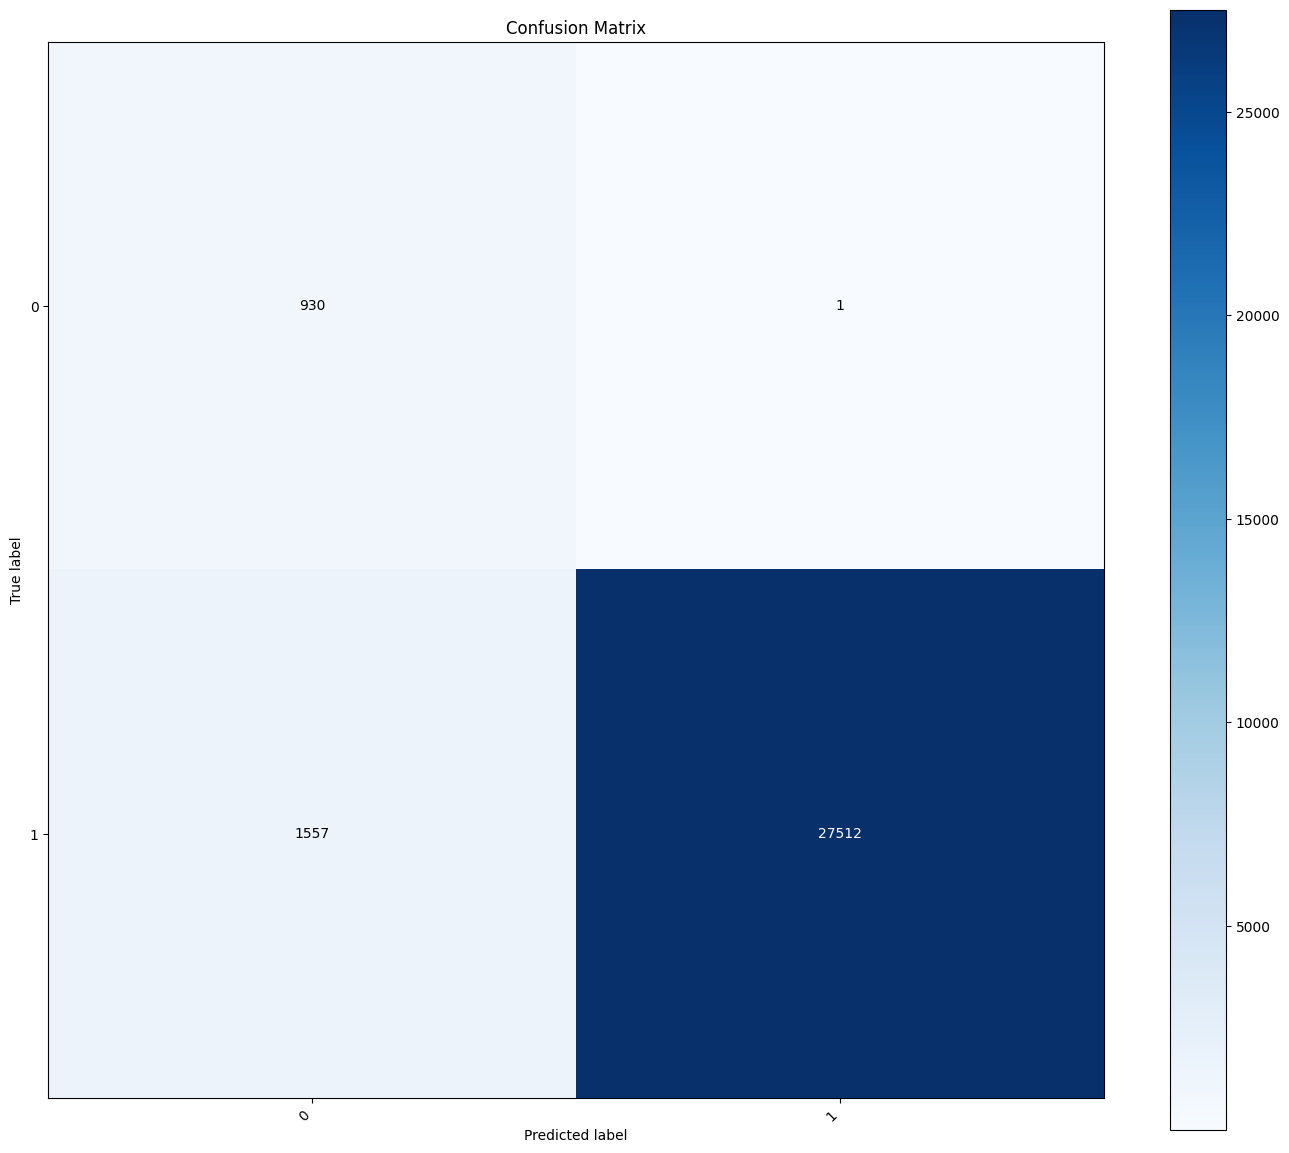

<Figure size 500x500 with 0 Axes>

-------------------------- END ID3 --------------------------


In [5]:
print("---------------------- ID3 --------------------------")    
start_time = time.time()
decision_tree: DecisionTreeID3 = DecisionTreeID3(max_depth=10, 
                                                    num_thresholds_numerical_attr=6)
decision_tree.fit(X_train, y_train)
end_time = time.time()
decision_tree.create_dot_files(filename="tree-id3-diabetes", generate_png=True, view="")
print()
print("Performances: ")
predictions = list(decision_tree.predict_test(X_test))
print(f"Fit time: {end_time - start_time} seconds") 
calculate_performances(predictions, y_test, "id3", verbose=True)
print("-------------------------- END ID3 --------------------------")

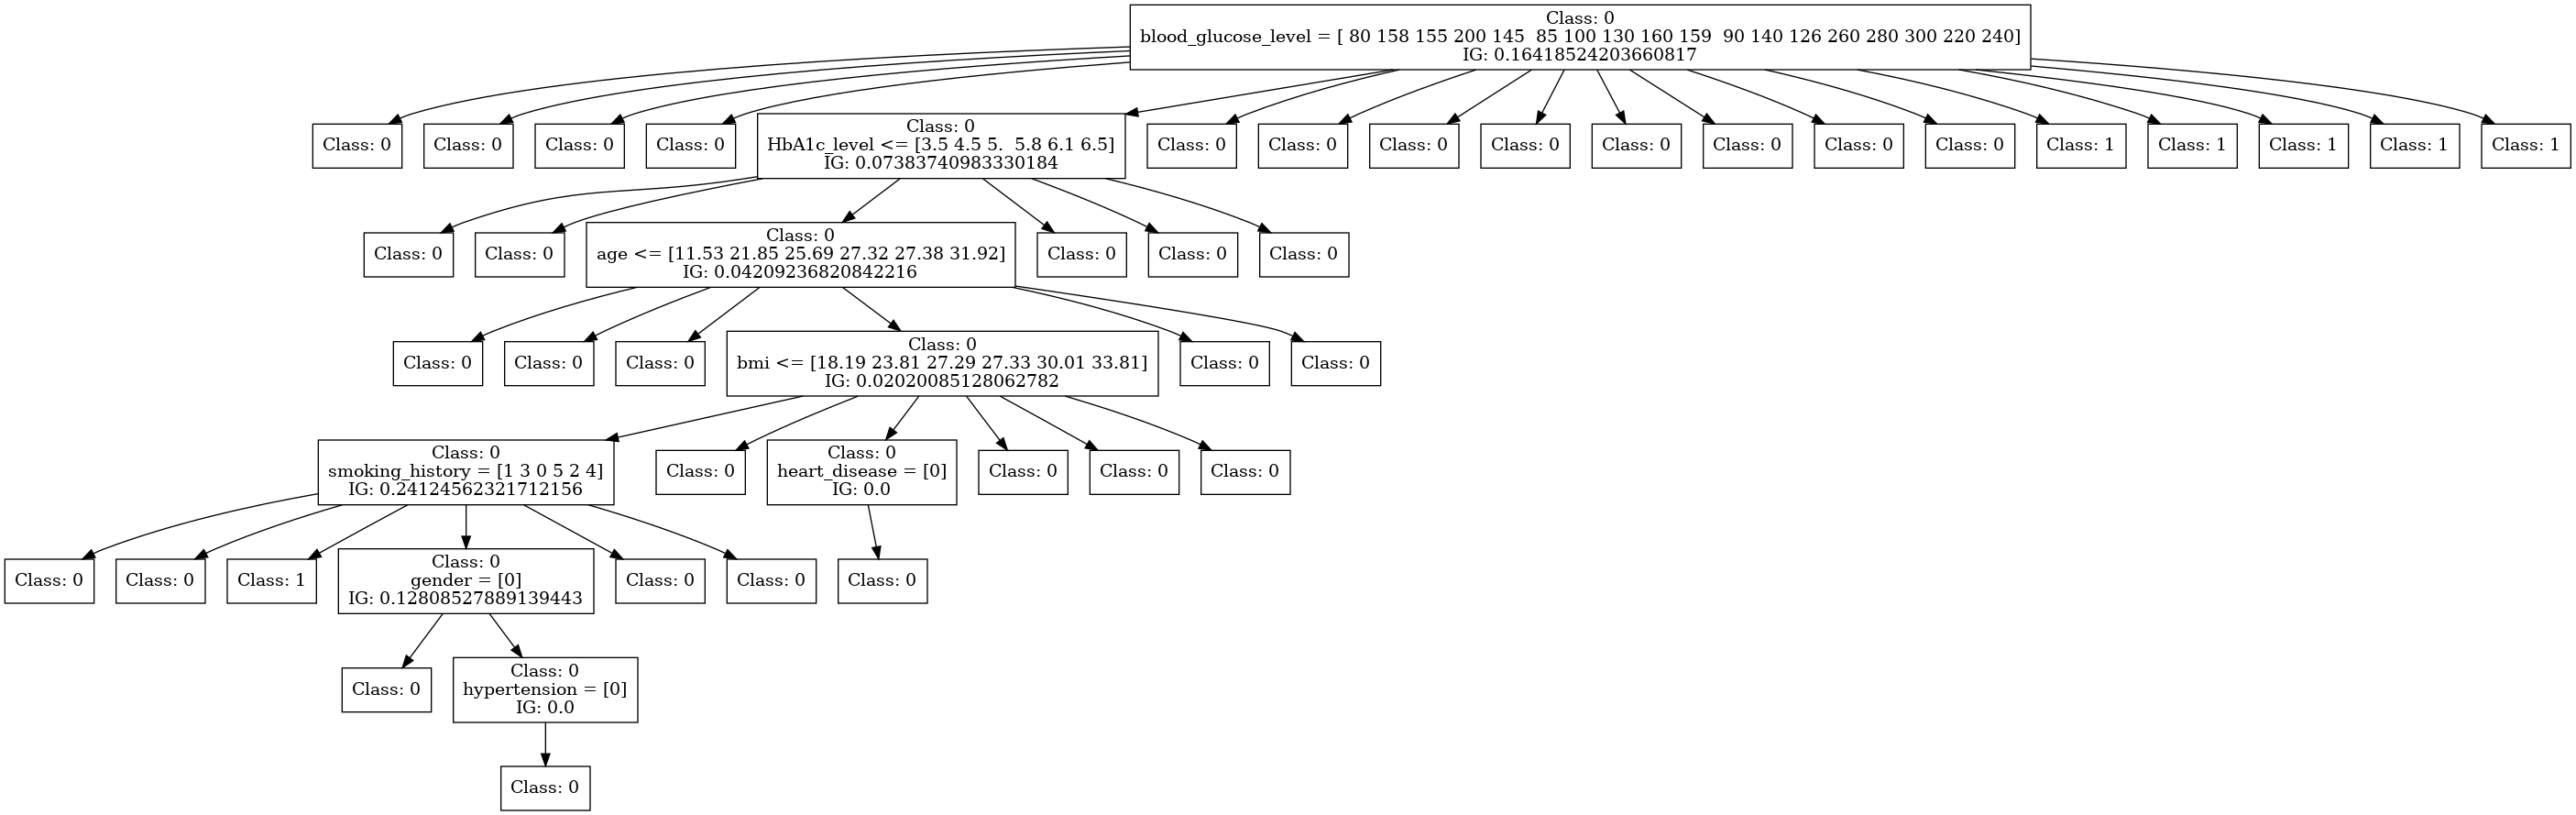

In [6]:
display(Image(filename='./dot_figs/tree-id3-diabetes.png'))

### Custom

-------------------------- CUSTOM --------------------------
PARAMETERS:
	CRITERION: Entropy
	TYPE CRITERION: Best
	MAX DEPTH: 10
	MIN SAMPLES SPLIT: 20
	NUM THRESHOLDS NUMERICAL ATTR: 6


Performances: 
Fit time: 18.567959308624268 seconds
F1 score: 0.8025999037072701
Accuracy: 0.9726666666666667
Precision: 1.0
Recall: 0.6702854845195014
True positive:  1667
True negative:  27513
False positive:  0
False negative:  820
True positive rate: 0.6702854845195014
False positive rate: 0.0


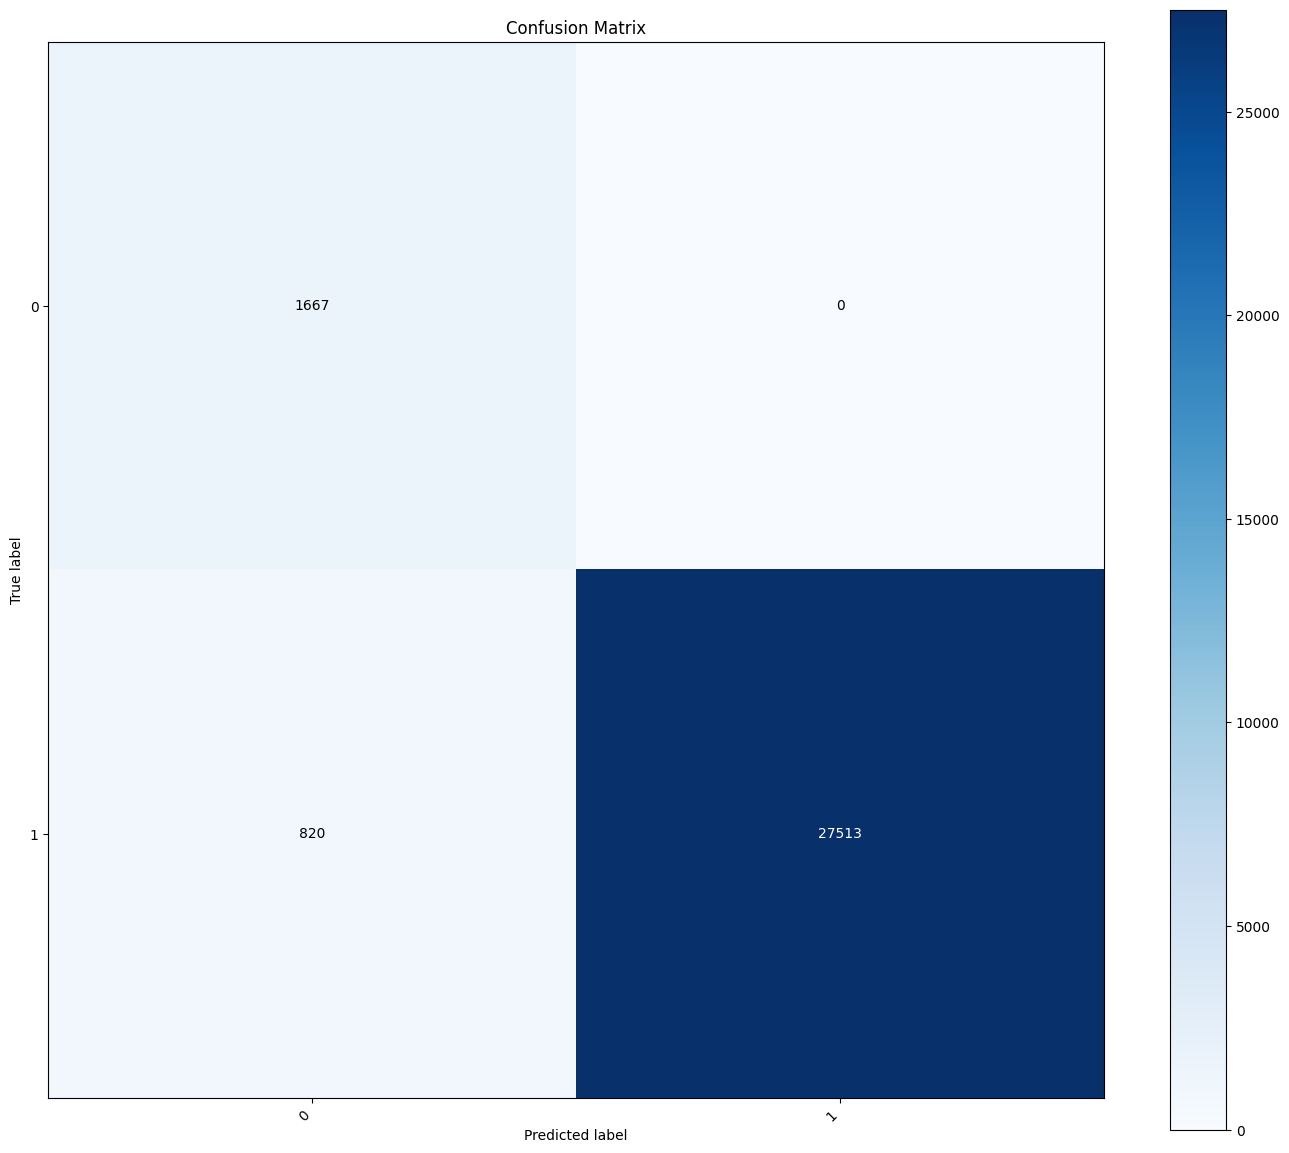

<Figure size 500x500 with 0 Axes>

-------------------------- END CUSTOM --------------------------


In [8]:
print("-------------------------- CUSTOM --------------------------")
start_time = time.time()
decision_tree = CustomDecisionTree(criterion=EntropyType.SHANNON, 
                                    type_criterion=CriterionType.BEST, 
                                    max_depth=10, 
                                    min_samples_split=20,
                                    num_thresholds_numerical_attr=6)
decision_tree.fit(X_train, y_train)
end_time = time.time()
decision_tree.create_dot_files(filename="tree-custom-diabetes", generate_png=True, view="")
print()
print("Performances: ") 
predictions = list(decision_tree.predict_test(X_test))
print(f"Fit time: {end_time - start_time} seconds")
calculate_performances(predictions, y_test, "custom", verbose=True)
print("-------------------------- END CUSTOM --------------------------")

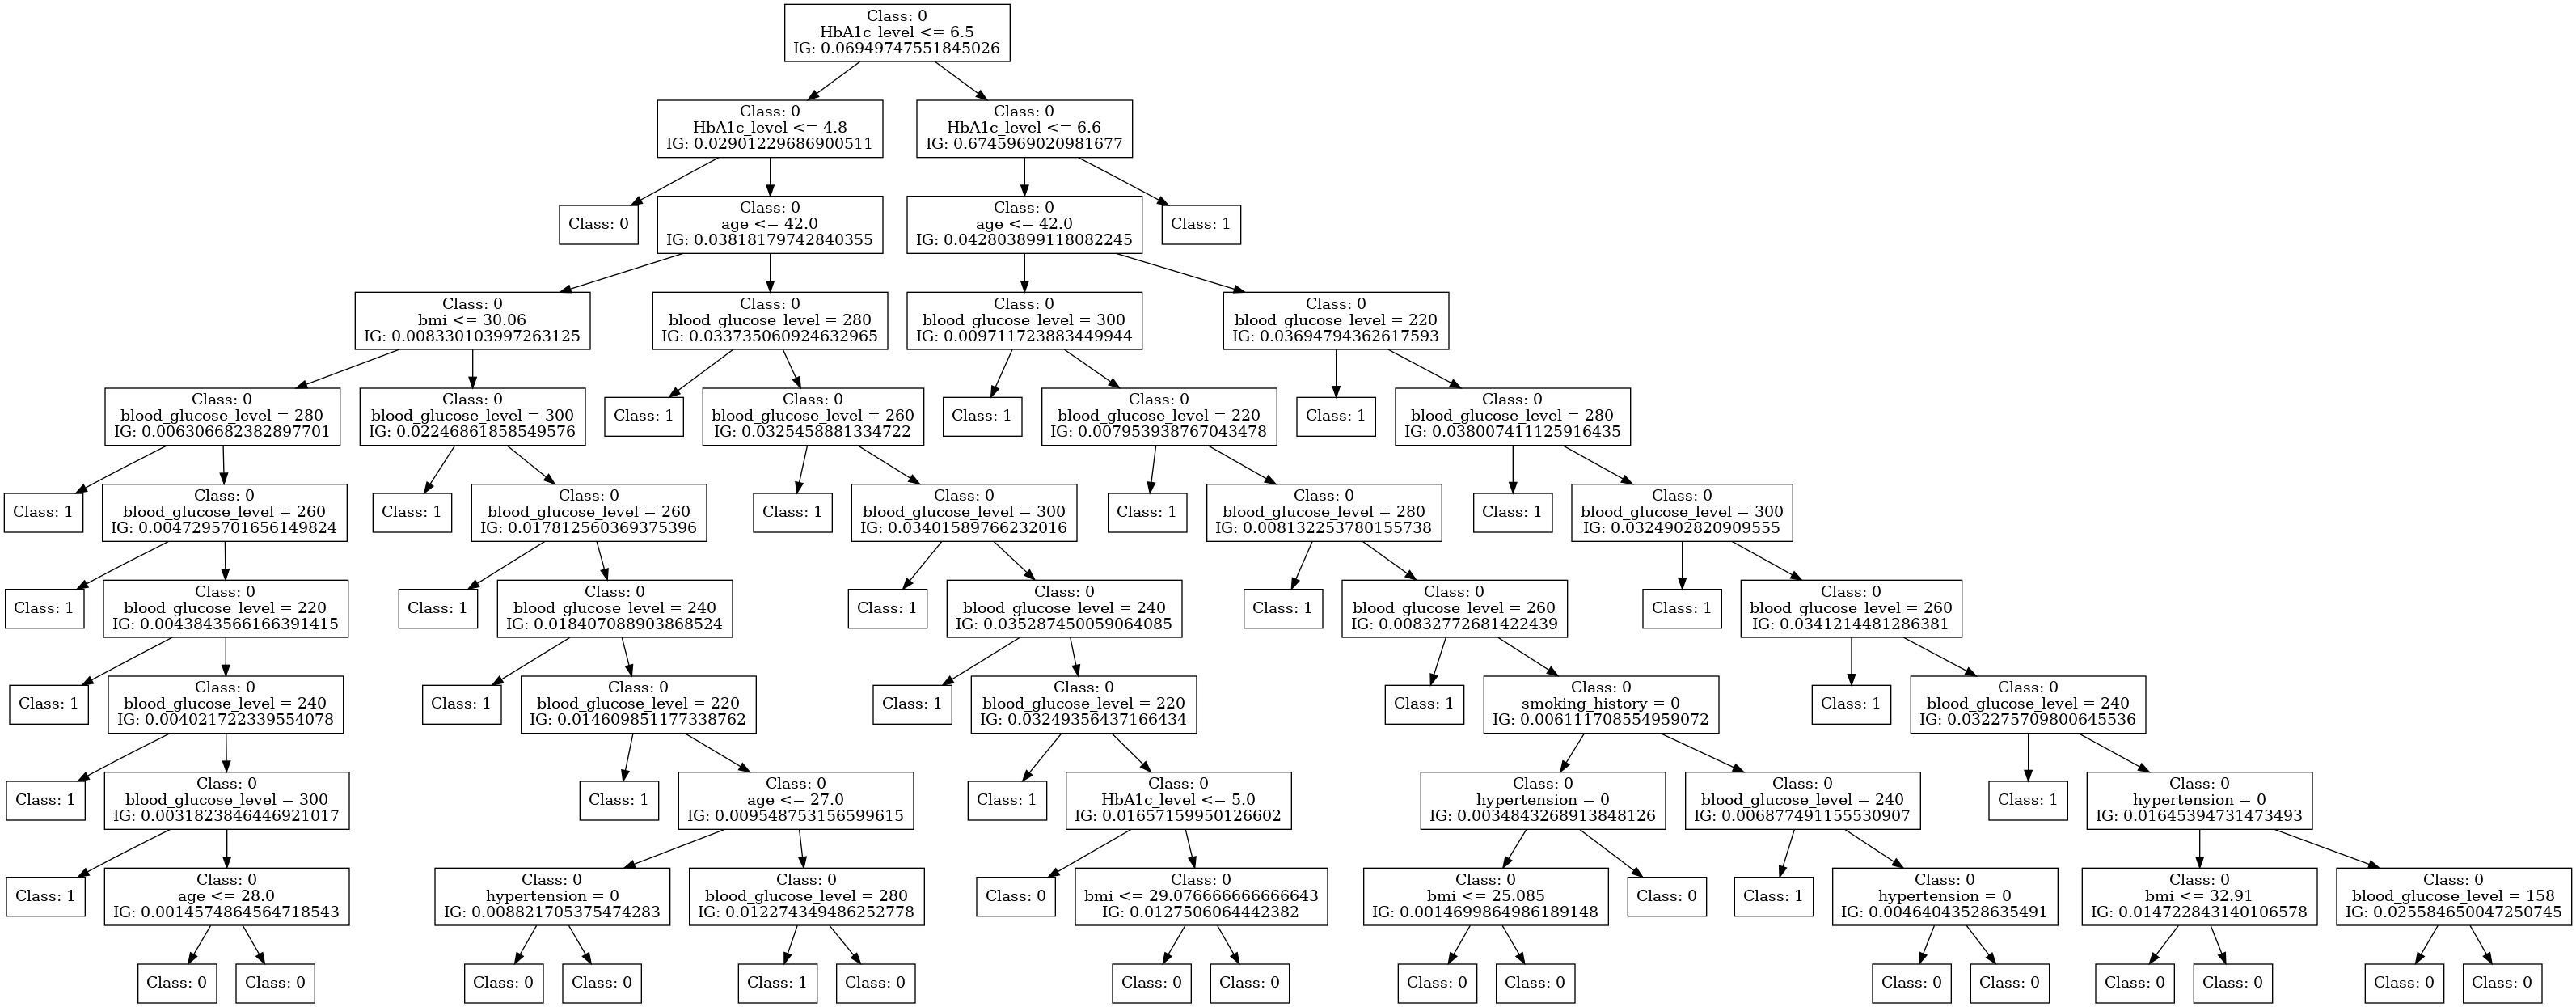

In [9]:
display(Image(filename='./dot_figs/tree-custom-diabetes.png'))

## IBM Money Laundering Dataset

In [10]:
original_df_train, original_df_test = get_train_and_test(hi_small_trans, verbose=VERBOSE)
original_df_train, _ = label_encoder(original_df_train, ['Timestamp', 'Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format'])
original_df_test, _ = label_encoder(original_df_test, ['Timestamp', 'Account', 'Account.1', 'Receiving Currency', 'Payment Currency', 'Payment Format'])

### ID3

In [6]:
hp_n_thresholds_values = [2, 4, 6]

def id3_experiment(df_train, df_test, type):
    X_train, y_train = get_X_and_Y(df_train, verbose=VERBOSE)
    X_test, y_test = get_X_and_Y(df_test, verbose=VERBOSE)
    
    for hp_n_thresholds in hp_n_thresholds_values:
        print(f"\nNumber of thresholds: {hp_n_thresholds}")
        start_time = time.time()
        decision_tree: DecisionTreeID3 = DecisionTreeID3(num_thresholds_numerical_attr=hp_n_thresholds)
        decision_tree.fit(X_train, y_train)
        end_time = time.time()
        decision_tree.create_dot_files(filename=f"tree-id3-{type}-{hp_n_thresholds}", generate_png=True, view=VIEW)
        print("\nPerformances: ")
        predictions = list(decision_tree.predict_test(X_test))
        print(f"Fit time: {end_time - start_time} seconds") 
        calculate_performances(predictions, y_test, "id3", verbose=True)

In [ ]:
print("\nWithout preprocessing")
df_train, df_test = original_df_train, original_df_test
id3_experiment(df_train, df_test, "wo_preprocessing")

In [6]:
print("\nPreprocessing: Undersampling")
df_train, df_test = original_df_train, original_df_test
df_train = undersampling(df_train, VERBOSE=False)
id3_experiment(df_train, df_test, "undersampling")


Preprocessing: Undersampling


NameError: name 'original_df_train' is not defined

In [ ]:
print("\nPreprocessing: Oversampling")
df_train, df_test = original_df_train, original_df_test
df_train = oversampling(df_train, VERBOSE=False)
id3_experiment(df_train, df_test, "oversampling")

### Custom